In [5]:
from config import *
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from models_local import *
import OFDM_SDR_Functions_torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = RXModel(Qm).to(device)

# load the testset
test_set = torch.load('data/ofdm_testset.pth')
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

# Load the trained model checkpoint
checkpoint_path = 'data/rx_model_50.pth'
checkpoint = torch.load(checkpoint_path)

# Load the model architecture
model.load_state_dict(checkpoint['model_state_dict'])

# Evaluate the model on the test set
model.eval()

test_losses = []
test_BERs = []

test_losses_ZFLS = []
test_BERs_ZFLS = []


criterion = nn.BCELoss()

with torch.no_grad():
    for test_pdsch_iq, test_pilot_iq, test_labels in test_loader:
        test_pdsch_iq, test_pilot_iq, test_labels = test_pdsch_iq.to(device), test_pilot_iq.to(device), test_labels.to(device)
        test_outputs = model((test_pdsch_iq, test_pilot_iq))
        test_loss = criterion(test_outputs, test_labels)

        # Convert probabilities to binary predictions (0 or 1)
        binary_predictions = torch.round(test_outputs)

        # Calculate Bit Error Rate (BER) with the NN-receiver
        error_count = torch.sum(binary_predictions != test_labels).float()  # Count of unequal bits
        error_rate = error_count / len(test_labels.flatten())  # Error rate calculation
        BER = torch.round(error_rate * 1000) / 1000  # Round to 3 decimal places

        # Calculate Bit Error Rate (BER) with the ZF-LS receiver
        # add DC and FFT offsets, as channel estimation expects those
         
        test_pdsch_iq = torch.cat((torch.zeros(1, FFT_offset, device=device), test_pdsch_iq, torch.zeros(1, FFT_offset, device=device)), dim=1)
        print(test_pdsch_iq.shape)
        middle_index = test_pdsch_iq.size(1) // 2
        test_pdsch_iq = torch.cat((test_pdsch_iq[:, :middle_index], torch.zeros(1, 1), test_pdsch_iq[:, middle_index:]), dim=1)
        print(test_pdsch_iq.shape)


        H_estim = OFDM_SDR_Functions_torch.channelEstimate_LS(TTI_mask_RE, pilot_symbols, F, FFT_offset, Sp, OFDM_demod, plotEst=False)

        OFDM_demod_no_offsets = OFDM_SDR_Functions_torch.remove_fft_Offests(OFDM_demod, config.F, config.FFT_offset)
        equalized_H_estim = OFDM_SDR_Functions_torch.equalize_ZF(OFDM_demod_no_offsets, H_estim, config.F, config.S)
        QAM_est = OFDM_SDR_Functions_torch.get_payload_symbols(TTI_mask_RE, equalized_H_estim, config.FFT_offset, config.F, plotQAM=False)
        PS_est, hardDecision = OFDM_SDR_Functions_torch.Demapping(QAM_est, de_mapping_table_Qm)
        bits_est = OFDM_SDR_Functions_torch.PS(PS_est)
        error_count = torch.sum(bits_est != pdsch_bits.flatten()).float()  # Count of unequal bits
        error_rate = error_count / bits_est.numel()  # Error rate calculation
        BER = torch.round(error_rate * 1000) / 1000  # Round to 3 decimal places



        test_losses.append(test_loss.item())
        test_BERs.append(BER.item())

# Calculate average test loss and BER
average_test_loss = sum(test_losses) / len(test_losses)
average_test_BER = sum(test_BERs) / len(test_BERs)

# Print or log average test loss and BER
print(f"Average Test Loss: {average_test_loss:.4f}, Average Test BER: {average_test_BER:.4f}")

cuda:0


RuntimeError: Tensors must have same number of dimensions: got 2 and 3

Average Test Loss: 0.2291, Average Test BER: 0.0871


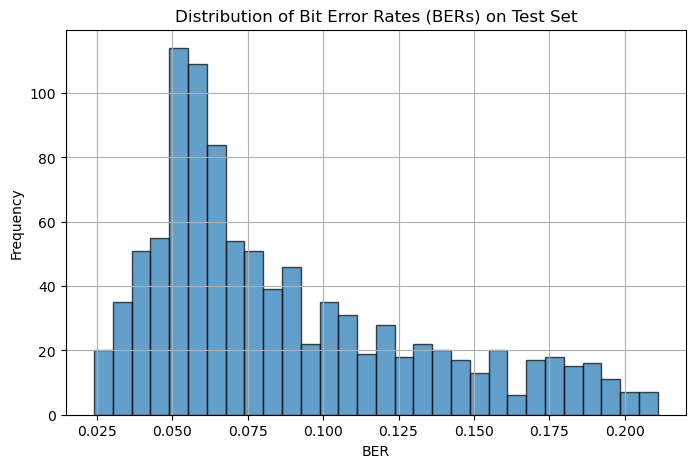

In [3]:
import matplotlib.pyplot as plt

# ... (Your existing code)

# Print or log average test loss and BER
print(f"Average Test Loss: {average_test_loss:.4f}, Average Test BER: {average_test_BER:.4f}")

# Plot the distribution of BERs
plt.figure(figsize=(8, 5))
plt.hist(test_BERs, bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Bit Error Rates (BERs) on Test Set')
plt.xlabel('BER')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()